In [9]:
%matplotlib inline
import torch
import pandas as pd
import numpy as np
import gdown
import zipfile
import json
import os
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torchvision.transforms.functional import to_pil_image
from torchvision.io import read_image 
import torchvision
import PIL
from sklearn.metrics import confusion_matrix, roc_curve, auc
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Load dataset

In [3]:
def select_equal_samples(data, label_column='label'):
    """ Select equal # of pos/neg samples """
    positive_samples = data[data[label_column] == True]
    negative_samples = data[data[label_column] == False]

    # Determine the number of samples to select (minimum of positive and negative samples)
    num_samples = min(len(positive_samples), len(negative_samples))

    # Randomly select equal number of positive and negative samples without replacement
    selected_positive_samples = positive_samples.sample(n=num_samples, random_state=42, replace=False)
    selected_negative_samples = negative_samples.sample(n=num_samples, random_state=42, replace=False)

    # Concatenate the selected samples
    selected_samples = pd.concat([selected_positive_samples, selected_negative_samples])

    return selected_samples

In [4]:
class HOG_PedestrianClassificationDataset(Dataset):

    def __init__(self, labels_csv, root_dir, balance_labels=True, transform=None):
        self.labels = pd.read_csv(labels_csv)
        if balance_labels:
            self.labels = select_equal_samples(self.labels)
        self.root_dir = root_dir
        self.transform = transform
        self.class_to_idx = {True: 1, False: 0}
        # self.image_files = sorted(self.labels['image'])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        row = self.labels.iloc[idx]
        image_name = row['image'] + ".npy"
        image_name = os.path.join(self.root_dir, image_name) 
        image = np.load(image_name)
        image = image.reshape(image.shape[0], image.shape[1], -1) # flatten last 3 dimensions
        image = torch.from_numpy(image.transpose((2,0,1))).float()
        label = self.class_to_idx[row['label']]
        if self.transform:
            image = self.transform(image)
        return (image, label)

In [5]:
dataset = HOG_PedestrianClassificationDataset("./processed_labels.csv","./road-waymo/hog-fd/", balance_labels=True, transform = None)
print(f"Dataset len:  {len(dataset)}")

sample = dataset[5000]
print(sample[0].shape)
# to_pil_image(sample[0])

Dataset len:  5174
torch.Size([36, 23, 35])


In [6]:
# Split training and testing
train_ratio = 0.8
val_ratio = 0.1

dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = dataset_size - train_size - val_size

# Use random_split to split the dataset into training and testing sets.
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [7]:
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Experiments

In [ ]:
# define model types for two experiments

In [16]:
num_epoch = 15 # TODO: change num_epoch to like 10 or 15 or something
def train(model, train_dataloader, val_dataloader, save_path):
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer =  torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    best_accuracy = 0.0
    val_error = []
    train_error = []
    
    for epoch in tqdm(range(num_epoch), desc="epochs"):  # loop over the dataset multiple times
        model.train()
        starttime = time()
        trainloss = 0
        for train_data in tqdm(train_dataloader, desc="training 1 epoch"):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = train_data

            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            trainloss += loss.cpu().item()
            optimizer.step()
            # break # TODO: delete this
        
        traintime = time() - starttime
        print(f"Epoch train time: {traintime}   Time per sample: {traintime / len(train_dataloader.dataset)}")
        train_error.append(trainloss / len(train_dataloader))
        
        # Validate
        valloss = 0
        correct = 0
        total = 0
        model.eval()
        all_predicted = torch.tensor([]).to(device)
        all_labels = torch.tensor([]).to(device)
        all_pred_probs = torch.tensor([]).to(device)
        with torch.no_grad():
            for images, labels in tqdm(val_dataloader, desc="Validating"):
                images = images.to(device)
                labels = labels.to(device)

                # calculate outputs by running images through the network
                outputs = model(images)
                valloss += criterion(outputs, labels).cpu().item()
                
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_predicted = torch.cat((all_predicted, predicted))
                all_labels = torch.cat((all_labels, labels))
                all_pred_probs = torch.cat((all_pred_probs, outputs.data))
                # break # TODO: delete this

        val_error.append(valloss / len(val_dataloader))
        
        conf_matrix = confusion_matrix(all_labels.cpu(), all_predicted.cpu())
        print("Val confusion matrix:")
        print(conf_matrix)
        print(f"{conf_matrix[0].sum().item()} frames don't have pedestrian, {conf_matrix[1].sum().item()} frames have pedestrian")
        
        tp = conf_matrix[0,0]
        fp = conf_matrix[1,0]
        fn = conf_matrix[0,1]
        print(f"TP: {tp}, FP: {fp}, FN: {fn}")
        print(f"Precision: {tp/(tp+fp)}, Recall: {tp/(tp+fn)}")

        accuracy = 100 * correct / total
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            print(f"Epoch {epoch}: Saving model to {save_path} with val accuracy {accuracy}%")
            torch.save(model.state_dict(), save_path)
    return train_error, val_error

In [18]:
save_path = "./checkpoints/resnet18_HOG_fd_gpu"

model = torchvision.models.resnet18(weights = None)
model.conv1 = torch.nn.Conv2d(2*2*9, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = torch.nn.Linear(in_features=512, out_features=2, bias=True)
model = torch.nn.DataParallel(model)

try:
    model.load_state_dict(torch.load(save_path))
    print("Successfully Loaded Saved Model")
except Exception as error:
    print("Failed to load Saved Model")
    print(error)
model.to(device)

train_errors, val_errors = train(model, train_dataloader, val_dataloader, save_path)

Failed to load Saved Model
[Errno 2] No such file or directory: './checkpoints/resnet18_HOG_fd_gpu'


training 1 epoch: 100%|████████████████████████████████████████████████████████████████| 65/65 [00:10<00:00,  6.47it/s]


Epoch train time: 10.047971725463867   Time per sample: 0.002427632695207506



epochs:  10%|███████▌                                                                   | 1/10 [00:11<01:40, 11.13s/it]

Val confusion matrix:
[[251   3]
 [ 49 214]]
254 frames don't have pedestrian, 263 frames have pedestrian
TP: 251, FP: 49, FN: 3
Precision: 0.8366666666666667, Recall: 0.9881889763779528
Epoch 0: Saving model to ./checkpoints/resnet18_HOG_fd_gpu with val accuracy 89.94197292069633%



training 1 epoch: 100%|████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 17.84it/s]


Epoch train time: 3.6428425312042236   Time per sample: 0.0008801262457608658



epochs:  20%|███████████████                                                            | 2/10 [00:15<00:55,  6.96s/it]

Val confusion matrix:
[[253   1]
 [ 24 239]]
254 frames don't have pedestrian, 263 frames have pedestrian
TP: 253, FP: 24, FN: 1
Precision: 0.9133574007220217, Recall: 0.9960629921259843
Epoch 1: Saving model to ./checkpoints/resnet18_HOG_fd_gpu with val accuracy 95.16441005802707%



training 1 epoch: 100%|████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.64it/s]


Epoch train time: 3.486281156539917   Time per sample: 0.0008423003519062375



epochs:  30%|██████████████████████▌                                                    | 3/10 [00:19<00:38,  5.55s/it]

Val confusion matrix:
[[251   3]
 [  2 261]]
254 frames don't have pedestrian, 263 frames have pedestrian
TP: 251, FP: 2, FN: 3
Precision: 0.9920948616600791, Recall: 0.9881889763779528
Epoch 2: Saving model to ./checkpoints/resnet18_HOG_fd_gpu with val accuracy 99.03288201160541%



training 1 epoch: 100%|████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.90it/s]


Epoch train time: 3.4387502670288086   Time per sample: 0.0008308166868878494



epochs:  40%|██████████████████████████████                                             | 4/10 [00:22<00:29,  4.85s/it]

Val confusion matrix:
[[249   5]
 [  3 260]]
254 frames don't have pedestrian, 263 frames have pedestrian
TP: 249, FP: 3, FN: 5
Precision: 0.9880952380952381, Recall: 0.9803149606299213



training 1 epoch: 100%|████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.98it/s]


Epoch train time: 3.424670457839966   Time per sample: 0.0008274149451171698



epochs:  50%|█████████████████████████████████████▌                                     | 5/10 [00:26<00:22,  4.48s/it]

Val confusion matrix:
[[252   2]
 [  2 261]]
254 frames don't have pedestrian, 263 frames have pedestrian
TP: 252, FP: 2, FN: 2
Precision: 0.9921259842519685, Recall: 0.9921259842519685
Epoch 4: Saving model to ./checkpoints/resnet18_HOG_fd_gpu with val accuracy 99.22630560928434%



training 1 epoch: 100%|████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.99it/s]


Epoch train time: 3.423347234725952   Time per sample: 0.0008270952487861687



epochs:  60%|█████████████████████████████████████████████                              | 6/10 [00:30<00:17,  4.26s/it]

Val confusion matrix:
[[253   1]
 [  2 261]]
254 frames don't have pedestrian, 263 frames have pedestrian
TP: 253, FP: 2, FN: 1
Precision: 0.9921568627450981, Recall: 0.9960629921259843
Epoch 5: Saving model to ./checkpoints/resnet18_HOG_fd_gpu with val accuracy 99.41972920696325%



training 1 epoch: 100%|████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.82it/s]


Epoch train time: 3.454611301422119   Time per sample: 0.0008346487802421163



epochs:  70%|████████████████████████████████████████████████████▌                      | 7/10 [00:34<00:12,  4.10s/it]

Val confusion matrix:
[[250   4]
 [  2 261]]
254 frames don't have pedestrian, 263 frames have pedestrian
TP: 250, FP: 2, FN: 4
Precision: 0.9920634920634921, Recall: 0.984251968503937



training 1 epoch: 100%|████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.99it/s]


Epoch train time: 3.4227170944213867   Time per sample: 0.0008269430042090811



epochs:  80%|████████████████████████████████████████████████████████████               | 8/10 [00:37<00:07,  3.99s/it]

Val confusion matrix:
[[253   1]
 [  2 261]]
254 frames don't have pedestrian, 263 frames have pedestrian
TP: 253, FP: 2, FN: 1
Precision: 0.9921568627450981, Recall: 0.9960629921259843



training 1 epoch: 100%|████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.99it/s]


Epoch train time: 3.4382405281066895   Time per sample: 0.0008306935317967357



epochs:  90%|███████████████████████████████████████████████████████████████████▌       | 9/10 [00:41<00:03,  3.92s/it]

Val confusion matrix:
[[250   4]
 [  2 261]]
254 frames don't have pedestrian, 263 frames have pedestrian
TP: 250, FP: 2, FN: 4
Precision: 0.9920634920634921, Recall: 0.984251968503937



training 1 epoch: 100%|████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.99it/s]


Epoch train time: 3.4232094287872314   Time per sample: 0.0008270619542853905



epochs: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [00:45<00:00,  4.55s/it]

Val confusion matrix:
[[250   4]
 [  2 261]]
254 frames don't have pedestrian, 263 frames have pedestrian
TP: 250, FP: 2, FN: 4
Precision: 0.9920634920634921, Recall: 0.984251968503937


In [19]:
def test(model, test_dataloader, save_path, test_type):
    starttime = time()
    correct = 0
    total = 0
    model.eval()
    all_predicted = torch.tensor([]).to(device)
    all_labels = torch.tensor([]).to(device)
    all_pred_probs = torch.tensor([]).to(device)
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, labels in tqdm(test_dataloader, desc="testing"):
            images = images.to(device)
            labels = labels.to(device)

            # calculate outputs by running images through the network
            outputs = model(images)

            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predicted = torch.cat((all_predicted, predicted))
            all_labels = torch.cat((all_labels, labels))
            all_pred_probs = torch.cat((all_pred_probs, outputs.data))
            # break # TODO: remove this
    
    testtime = time() - starttime
    print(f"Total test time: {testtime}   Time per sample: {testtime / len(test_dataloader.dataset)}")
    # Let's say y_true is your true binary labels and y_pred_probs is the predicted probabilities for the positive class
    # You should replace them with your actual variables

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(all_labels.cpu(), all_pred_probs[:,1].cpu(), pos_label=1)
    roc_auc = auc(fpr, tpr)
    print("ROC curve area:", roc_auc)

    # Plotting the ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")

    conf_matrix = confusion_matrix(all_labels.cpu(), all_predicted.cpu())
    print(conf_matrix)
    print(f"{conf_matrix[0].sum().item()} frames don't have pedestrian, {conf_matrix[1].sum().item()} frames have pedestrian")
    tp = conf_matrix[0,0]
    fp = conf_matrix[1,0]
    fn = conf_matrix[0,1]
    print(f"TP: {tp}, FP: {fp}, FN: {fn}")
    print(f"Precision: {tp/(tp+fp)}, Recall: {tp/(tp+fn)}")
    accuracy = 100 * correct / total
    print(f"Accuracy for {save_path}: {accuracy}")
    plt.show()

Successfully Loaded Saved Model


testing: 100%|███████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.38it/s]

Total test time: 1.6876285076141357   Time per sample: 0.003257970091919181
ROC curve area: 0.9990159828244275
[[256   6]
 [  4 252]]
262 frames don't have pedestrian, 256 frames have pedestrian
TP: 256, FP: 4, FN: 6
Precision: 0.9846153846153847, Recall: 0.9770992366412213
Accuracy for ./checkpoints/resnet18_HOG_fd_gpu: 98.06949806949807


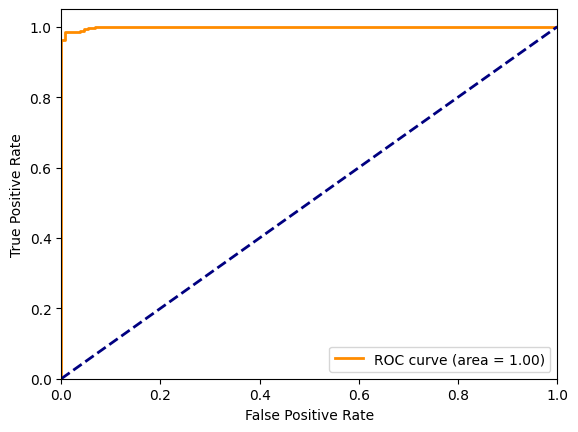

In [20]:
model = torchvision.models.resnet18(weights = None)
model.conv1 = torch.nn.Conv2d(2*2*9, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = torch.nn.Linear(in_features=512, out_features=2, bias=True)
model = torch.nn.DataParallel(model)
try:
    model.load_state_dict(torch.load(save_path))
    print("Successfully Loaded Saved Model")
except Exception as error:
    print("Failed to load Saved Model")
    print(error)
model.to(device)

test(model, test_dataloader, save_path, "HOG")

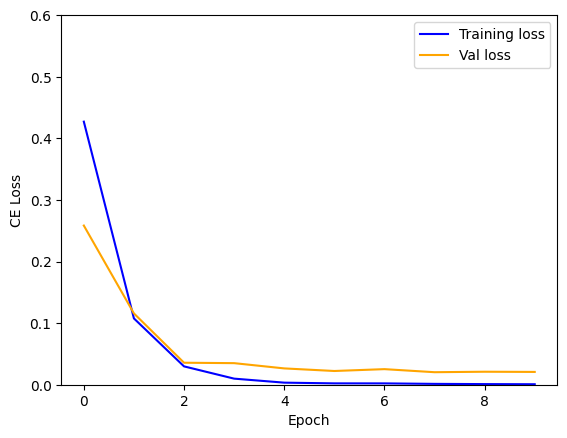

In [23]:
# Plot convergence
plt.plot(train_errors, label='Training loss', color='blue')
plt.plot(val_errors, label='Val loss',color='orange')
plt.ylabel("CE Loss")
plt.xlabel("Epoch")
plt.ylim([0,0.6])
plt.legend()